In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [9, 6]

import sys
sys.path.append("../derrom/")

import derrom

In [2]:
import torch

In [3]:
trajectories = derrom.utils.load_trajectories(filename='../../trajectories_n_kmax=200.npz')

trajectories = trajectories[::10]

n_trajectories = len(trajectories)
n_kmax = trajectories[0].shape[1]

print(n_trajectories, 'loaded with n_kmax =', n_kmax)


test_trajectory = derrom.utils.load_trajectories(filename='../../example_trajectory.npz')[0]
print('example trajectory loaded with shape: ', test_trajectory.shape)

100 loaded with n_kmax = 200
example trajectory loaded with shape:  (400, 200)


In [4]:
# data_matrix = np.concatenate(trajectories)
# data_matrix = np.concatenate([t[[0,5,10,20,50,100,200,399]] for t in trajectories])
data_matrix = np.concatenate([t[[0,50,100,399]] for t in trajectories])

print(data_matrix.shape)

(400, 200)


In [5]:
# print(data_matrix.dtype)

data_tensor = torch.from_numpy(data_matrix.astype(np.float32))
print(data_tensor.shape)
print(data_tensor.dtype)

torch.Size([400, 200])
torch.float32


In [6]:
class AE(torch.nn.Module):
    def __init__(self):
        super().__init__()
         
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(200, 40),
            torch.nn.Tanh(),
            torch.nn.Linear(40, 20),
            torch.nn.Tanh(),
#             torch.nn.Linear(40, 20),
#             torch.nn.Tanh(),
            torch.nn.Linear(20, 10),
        )
         
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(10, 20),
#             torch.nn.Tanh(),
#             torch.nn.Linear(20, 40),
            torch.nn.Tanh(),
            torch.nn.Linear(20, 40),
            torch.nn.Tanh(),
            torch.nn.Linear(40, 200),
        )
 
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [7]:
#### Model Initialization
model = AE()
print(model)

AE(
  (encoder): Sequential(
    (0): Linear(in_features=200, out_features=40, bias=True)
    (1): Tanh()
    (2): Linear(in_features=40, out_features=20, bias=True)
    (3): Tanh()
    (4): Linear(in_features=20, out_features=10, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=40, bias=True)
    (3): Tanh()
    (4): Linear(in_features=40, out_features=200, bias=True)
  )
)


In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [9]:


def PI_loss(output, target):
    loss = torch.mean((output-target)**2) + 0.01*torch.mean( torch.tanh(-20.*(output+0.2)) + 1 )
#     loss = torch.mean((output-target)**2) + torch.mean( torch.nn.functional.relu(-100.*output) )
    return loss

criterion = PI_loss
# criterion = torch.nn.MSELoss()

In [10]:
def train(net, states, NUM_EPOCHS):
    train_loss = []
    for epoch in range(NUM_EPOCHS):
        running_loss = 0.0
        for data in states:
            optimizer.zero_grad()
            outputs = net(data)
            loss = criterion(outputs, data)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        loss = running_loss / len(states)
        train_loss.append(loss)
        print('Epoch {} of {}, Train Loss: {:.6f}'.format(
            epoch+1, NUM_EPOCHS, loss))
    return train_loss


In [11]:
# get the computation device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# load the neural network onto the device
model.to(device)

cpu


AE(
  (encoder): Sequential(
    (0): Linear(in_features=200, out_features=40, bias=True)
    (1): Tanh()
    (2): Linear(in_features=40, out_features=20, bias=True)
    (3): Tanh()
    (4): Linear(in_features=20, out_features=10, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=40, bias=True)
    (3): Tanh()
    (4): Linear(in_features=40, out_features=200, bias=True)
  )
)

In [12]:
# train the network
train_loss = train(model, data_tensor, 100)

Epoch 1 of 100, Train Loss: 0.017863
Epoch 2 of 100, Train Loss: 0.006703
Epoch 3 of 100, Train Loss: 0.003983
Epoch 4 of 100, Train Loss: 0.003220
Epoch 5 of 100, Train Loss: 0.002758
Epoch 6 of 100, Train Loss: 0.002549
Epoch 7 of 100, Train Loss: 0.002283
Epoch 8 of 100, Train Loss: 0.002005
Epoch 9 of 100, Train Loss: 0.001939
Epoch 10 of 100, Train Loss: 0.001920
Epoch 11 of 100, Train Loss: 0.001908
Epoch 12 of 100, Train Loss: 0.001919
Epoch 13 of 100, Train Loss: 0.001925
Epoch 14 of 100, Train Loss: 0.001868
Epoch 15 of 100, Train Loss: 0.001844
Epoch 16 of 100, Train Loss: 0.001905
Epoch 17 of 100, Train Loss: 0.001816
Epoch 18 of 100, Train Loss: 0.001679
Epoch 19 of 100, Train Loss: 0.001585
Epoch 20 of 100, Train Loss: 0.001495
Epoch 21 of 100, Train Loss: 0.001630
Epoch 22 of 100, Train Loss: 0.001435
Epoch 23 of 100, Train Loss: 0.001461
Epoch 24 of 100, Train Loss: 0.001395
Epoch 25 of 100, Train Loss: 0.001406
Epoch 26 of 100, Train Loss: 0.001325
Epoch 27 of 100, Trai

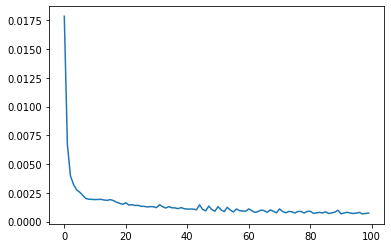

In [13]:
plt.plot(train_loss)
plt.show()

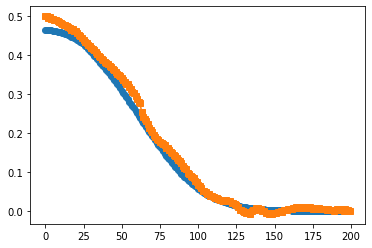

In [14]:
test = data_tensor[23]

recon = model(test).detach().numpy()

plt.plot(test, marker='o')
plt.plot(recon, marker = 's')

plt.show()

In [15]:
torch.save(model, '../torch_model_test')

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


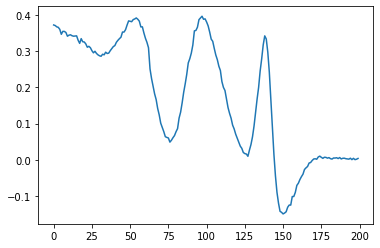

In [16]:
latent_vec = torch.zeros(10, dtype=torch.float32)

latent_vec[0] = 1

print(latent_vec)

data = model.decoder(latent_vec).detach().numpy()

plt.plot(data)
plt.show()


In [17]:
class AEDR(derrom.dim_reducers.base_dim_reducer):
    def __init__(self, AEmodel=None):
        self.AEmodel = AEmodel
    
    def train(self, data_matrix, rdim):
        pass
    
    def reduce(self, data_matrix, rdim):
        data_tensor = torch.from_numpy(data_matrix.astype(np.float32))
        
        out = np.zeros((data_tensor.shape[0],10))
        for k in range(data_tensor.shape[0]):
            out[k] = self.AEmodel.encoder(data_tensor[k]).detach().numpy()
        return out
    
    def reconstruct(self, reduced_data_matrix):
        data_tensor = torch.from_numpy(reduced_data_matrix.astype(np.float32))
        
        out = np.zeros((data_tensor.shape[0],200))
        for k in range(data_tensor.shape[0]):
            out[k] = self.AEmodel.decoder(data_tensor[k]).detach().numpy()
        return out

        

In [18]:
dim_reducer = AEDR(model)

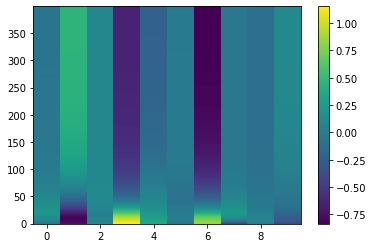

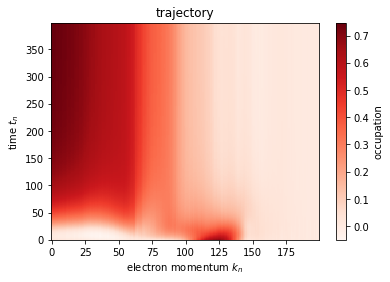

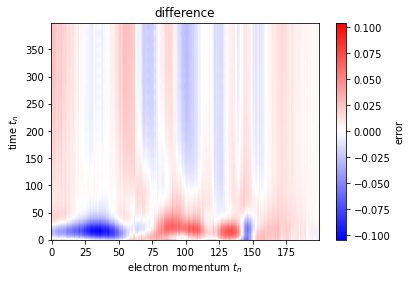

In [19]:
test = trajectories[33]

red = dim_reducer.reduce(test, rdim=10)

recon = dim_reducer.reconstruct(red)

plt.imshow(red, aspect='auto', interpolation='none', origin='lower')
plt.colorbar()
plt.show()

derrom.utils.plot_trajectory(recon)

derrom.utils.plot_difference(truth=test, test=recon)